In [1]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac_hals
from tlgcp import generalized_parafac, stochastic_generalized_parafac
import matplotlib.pyplot as plt
from tensorly.metrics import RMSE
from tlgcp.utils import loss_operator
import time

# How to use custom loss and gradient function
# -------------------------------------------

Tensorly-Gcp allows you to make use of your own loss within GCP. Under the hood, GCP relies on `scipy.minimize.lbfgs` which requires a vector (1D) input. Therefore your custom loss and gradient functions must take a vector input. To write the loss at the tensor level more easily, we provide some reshaping functions.

In [2]:
from tlgcp.generalized_parafac._generalized_parafac import vectorized_factors_to_tensor, vectorized_mttkrp

In GCP, we vectorize all the factors, however estimated tensor should be reconstructed inside the loss and gradient. Therefore, you should use `vectorized_factors_to_tensor(x, shape, rank)` to define estimated tensor in your function. Also, `vectorized_mttkrp(gradient, x , rank)` is necessary in your gradient function to follow GCP formulization, it simply computes and unfolds the MTTKRP. 
Knowing this, you can define your callable function, here e.g. as `fun_loss` and `fun_gradient`.

In [3]:
# note: size used before it is defined ??
fun_loss = lambda x: tl.sum((tensor - vectorized_factors_to_tensor(x, shape, rank)) ** 2) / size
fun_gradient = lambda x: vectorized_mttkrp(2 * (vectorized_factors_to_tensor(x, shape, rank) - tensor), x, rank) / size

In these functions, `x` represents vectorized factors. In our loss functions,  we use the size (total number of entries) of the tensor for normalization as it is suggested in Hong, Kolda and Duersch's paper, but it is not mandatory.

In [4]:
rank = 5
shape = [60, 80, 50]
cp_tensor = tl.cp_to_tensor(tl.random.random_cp(shape, rank))
array = np.random.binomial(1, cp_tensor / (cp_tensor + 1), size=shape)
tensor = tl.tensor(array, dtype='float')
size = tl.prod(tl.shape(tensor))

After we create a tensor and define necessary variables, we can apply GCP with our defined loss and gradient functions. It should be noted that, `loss` should be `None` to be able to use your functions. 

In [5]:
tic = time.time()
tensor_gcp, errors_gcp = generalized_parafac(tensor, rank=rank, return_errors=True, 
                                             loss=None, fun_loss=fun_loss, fun_gradient=fun_gradient)
cp_reconstruction_gcp = tl.cp_to_tensor((tensor_gcp))
time_gcp = time.time() - tic

As you may have noticed, the custom loss we used here is the Gaussian loss and its associated gradient. We can compare the results with the built-in Gaussian loss inside Tensorly-gcp.

In [6]:
loss="gaussian"
tic = time.time()
tensor_gcp_gaussian, errors_gcp_gaussian = generalized_parafac(tensor, rank=rank,return_errors=True, 
                                                               loss=loss)
cp_reconstruction_gcp_gaussian = tl.cp_to_tensor((tensor_gcp))
time_gcp_gaussian = time.time() - tic

In [7]:
print("RMSE for GCP:", RMSE(cp_tensor, cp_reconstruction_gcp))
print("RMSE for GCP:", RMSE(cp_tensor, cp_reconstruction_gcp_gaussian))

print("Loss for GCP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction_gcp, loss)))
print("Loss for GCP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction_gcp_gaussian, loss)))
, loss)))

print("GCP time:", time_gcp)
print("GCP time:", time_gcp_gaussian)

RMSE for GCP: 0.32660574169116274
RMSE for GCP: 0.32660574169116274
Loss for GCP: 0.10667131050563454
Loss for GCP: 0.10667131050563454
GCP time: 0.6412014961242676
GCP time: 0.791168212890625


As expected, results are very similar except processing time, the variation being due to random initialization. We can also observe this behaviour by plotting error per iteration for each method.

In [8]:
def each_iteration(a, b):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.plot(b)
    plt.yscale('log')
    plt.legend(['GCP-defined','GCP-gaussian'], loc='upper right') 

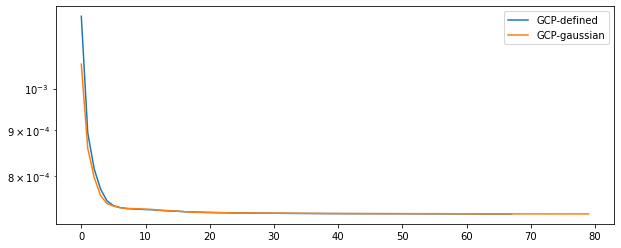

In [9]:
each_iteration(errors_gcp, errors_gcp_gaussian)